In [14]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


In [15]:
DATA_ROOT = "Data" 
pattern = re.compile(r"benchmark_(.+?)_(.+?)_(.+?)\.csv")
averages = defaultdict(lambda: {})
user_specs_cpu = {
    "Mert": "AMD Ryzen 7 5800H | NVIDIA RTX  3060",
    "Joel": "Intel i5-13400F | NVIDIA RTX  4070",
    "Joel2": "AMD Ryzen 5 7520U",
    "Hien": "Intel i7-1260P",
    "Edris": "M4",
    "T8": "Xeon W-2133"
}

In [16]:
for user in os.listdir(DATA_ROOT):
    user_path = os.path.join(DATA_ROOT, user)
    if not os.path.isdir(user_path):
        continue
    for fname in os.listdir(user_path):
        match = pattern.match(fname)
        if not match:
            continue
        user_name, model, device = match.groups()
        file_path = os.path.join(user_path, fname)
        df = pd.read_csv(file_path)
        avg = {
            "WER": df["WER"].mean(),
            "RTF": df["RTF"].mean(),
            "CPU_%": df["CPU_%"].mean(),
            "Mem_MB": df["Mem_MB"].mean(),
        }

        if device == "cuda":
            avg["GPU_MB_avg"] = df["GPU_MB_avg"].mean()
            avg["GPU_MB_peak"] = df["GPU_MB_peak"].mean()

        averages[(model, device)][user] = avg


In [ ]:
def group_rtf_score(group_key):
    model, device = group_key
    group_data = averages[(model, device)]

    rtf_values = [
        user_metrics["RTF"]
        for user_metrics in group_data.values()
        if "RTF" in user_metrics
    ]
    if len(rtf_values) == 0:
        return float("inf")  

    return sum(rtf_values) / len(rtf_values) 

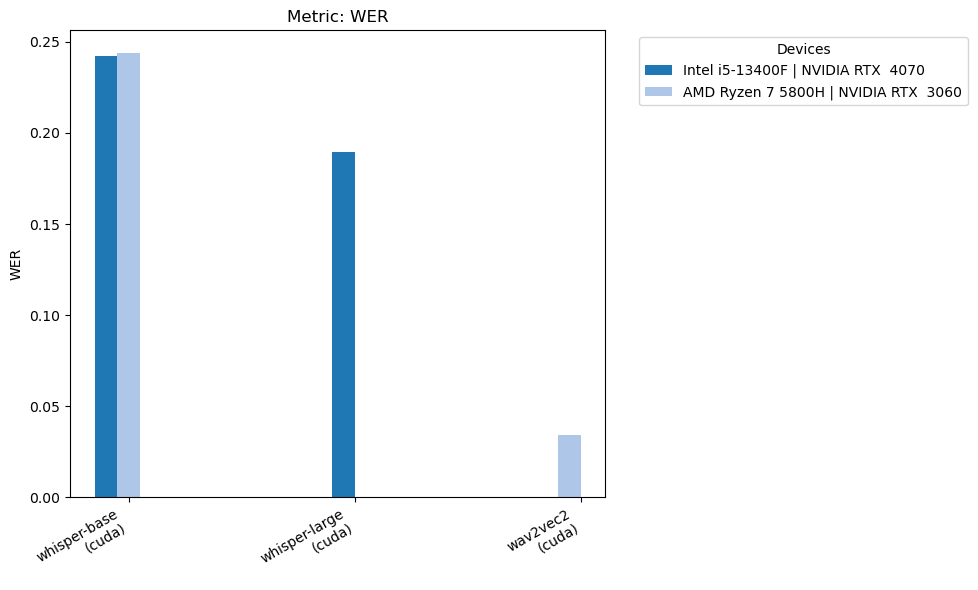

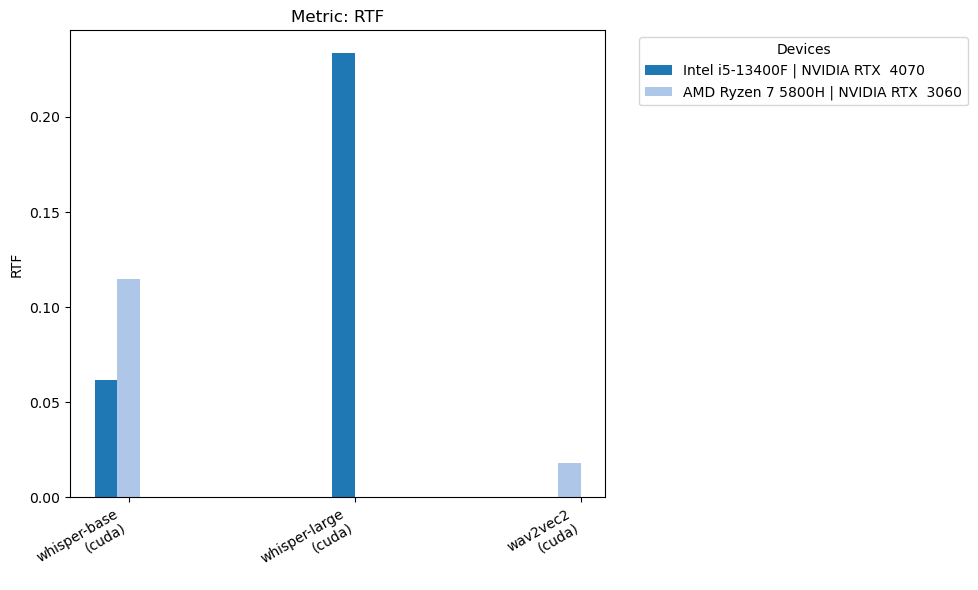

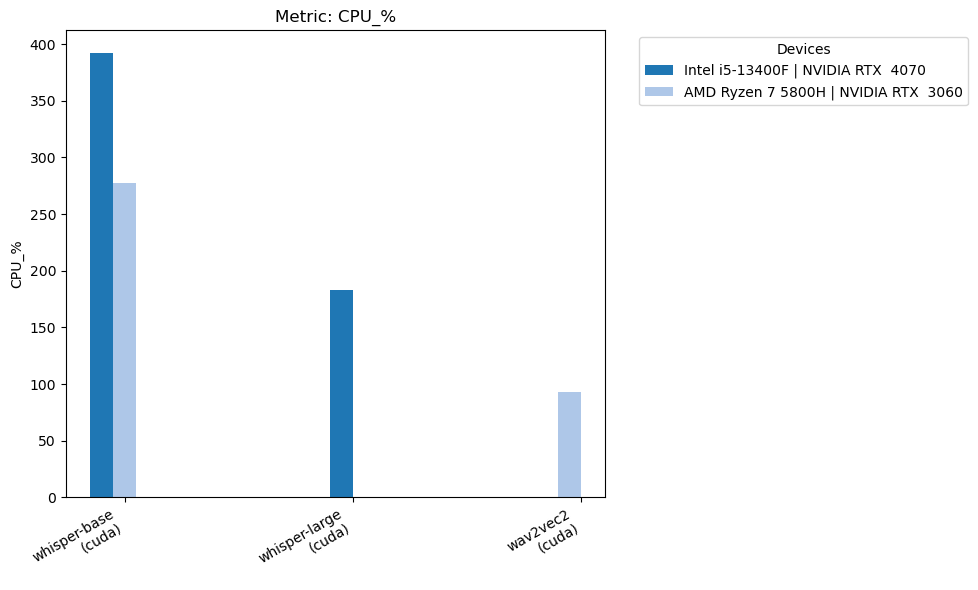

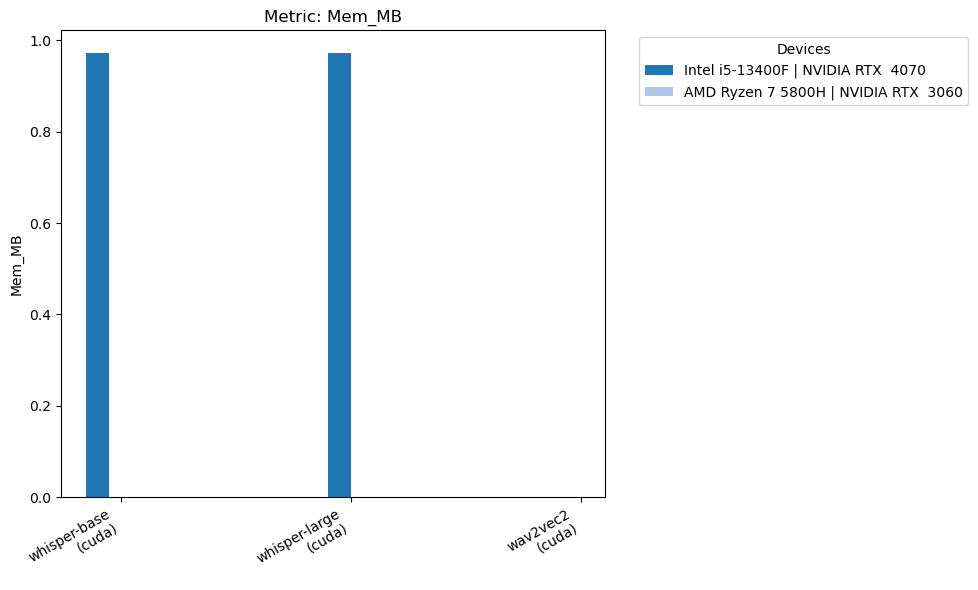

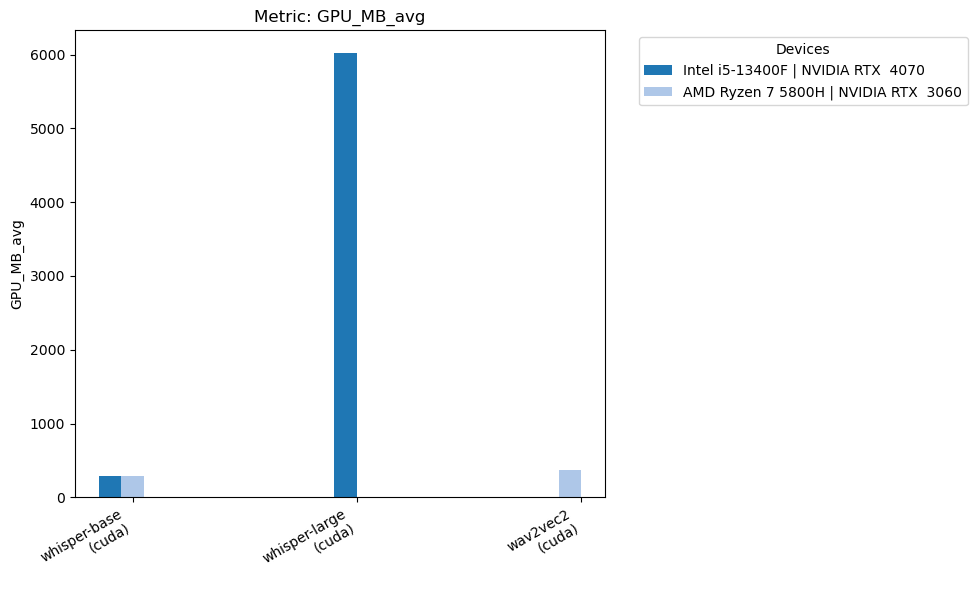

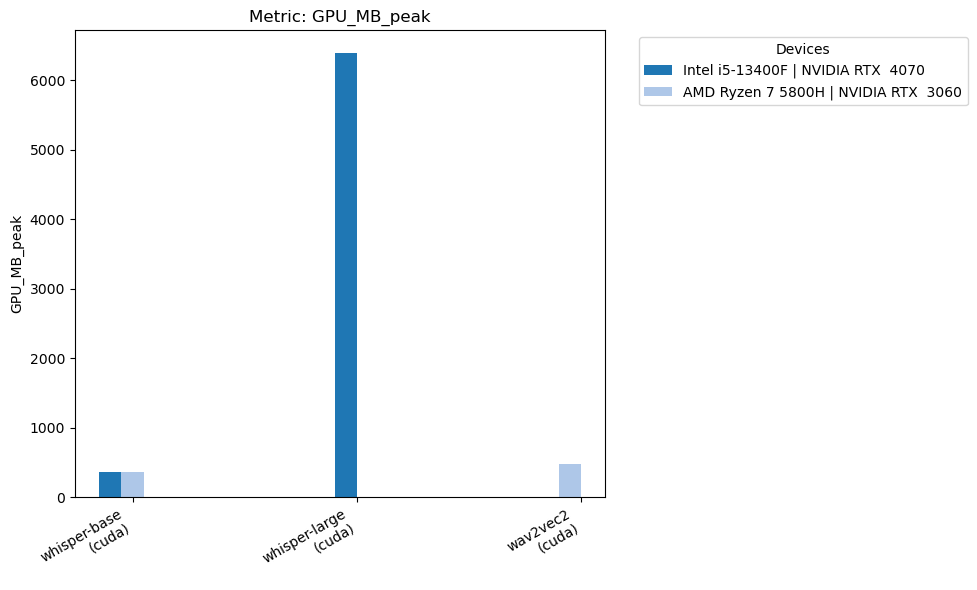

In [18]:
metrics = ["WER", "RTF", "CPU_%", "Mem_MB", "GPU_MB_avg", "GPU_MB_peak"]
all_users = sorted({
    user
    for combo in averages.values()
    for user in combo.keys()
})

color_map = {user: plt.cm.tab20(i % 20) for i, user in enumerate(all_users)}
BAR_WIDTH = 0.1    
for metric in metrics:
    has_any = any(
        metric in user_metrics
        for combo in averages.values()
        for user_metrics in combo.values()
    )
    if not has_any:
        continue
    plt.figure(figsize=(10, 6))
    plt.title(f"Metric: {metric}")
    plt.ylabel(metric)
    groups = list(averages.keys())
    for i, (model, device) in enumerate(groups):
        group_data = averages[(model, device)]
        present_users = [
            u for u in all_users
            if u in group_data and metric in group_data[u]
        ]

        n_present = len(present_users)
        if n_present == 0:
            continue
        total_width = BAR_WIDTH * n_present
        start_x = i - total_width / 2

        for j, user in enumerate(present_users):
            x = start_x + j * BAR_WIDTH
            value = group_data[user][metric]

            plt.bar(
                x, value,
                width=BAR_WIDTH,
                color=color_map[user],
                label=user_specs_cpu[user] if i == 0 else None
            )
    plt.xticks(
        range(len(groups)),
        [f"{m}\n({d})" for (m, d) in groups],
        rotation=30,
        ha="right"
    )
    plt.legend(title="Devices", bbox_to_anchor=(1.05, 1), loc="upper left")
    #plt.legend('',frameon=False)
    plt.tight_layout()
    plt.show()

In [19]:
print(all_users)

['Joel', 'Mert']


In [20]:
averages

defaultdict(<function __main__.<lambda>()>,
            {('whisper-base',
              'cuda'): {'Joel': {'WER': 0.24237461890504755,
               'RTF': 0.06145311783559899,
               'CPU_%': 392.57286324786327,
               'Mem_MB': 0.9730101304176526,
               'GPU_MB_avg': 288.5166015625,
               'GPU_MB_peak': 360.89565805288464}, 'Mert': {'WER': 0.24411499253372645,
               'RTF': 0.11455887632161735,
               'CPU_%': 277.1235042735043,
               'Mem_MB': 0.0,
               'GPU_MB_avg': 287.5166015625,
               'GPU_MB_peak': 359.8753203041533}},
             ('whisper-large',
              'cuda'): {'Joel': {'WER': 0.18936601034489603,
               'RTF': 0.23382871537649694,
               'CPU_%': 183.42970085470085,
               'Mem_MB': 0.9727870195339887,
               'GPU_MB_avg': 6026.7646484375,
               'GPU_MB_peak': 6397.127633380075}},
             ('wav2vec2',
              'cuda'): {'Mert': {'WER': 0

In [21]:
print("\n=== AVERAGE RESULTS ACROSS ALL USERS ===\n")

for (model, device), users_data in averages.items():
    print(f"Model: {model} | Device: {device}")
    all_metrics = set()
    for u in users_data.values():
        all_metrics.update(u.keys())
    for metric in all_metrics:
        values = [
            users_data[user][metric]
            for user in users_data
            if metric in users_data[user]
        ]
        if len(values) == 0:
            continue
        
        avg_value = sum(values) / len(values)
        print(f"  {metric}: {avg_value:.4f}")
    print()


=== AVERAGE RESULTS ACROSS ALL USERS ===

Model: whisper-base | Device: cuda
  GPU_MB_avg: 288.0166
  GPU_MB_peak: 360.3855
  Mem_MB: 0.4865
  RTF: 0.0880
  WER: 0.2432
  CPU_%: 334.8482

Model: whisper-large | Device: cuda
  GPU_MB_avg: 6026.7646
  GPU_MB_peak: 6397.1276
  Mem_MB: 0.9728
  RTF: 0.2338
  WER: 0.1894
  CPU_%: 183.4297

Model: wav2vec2 | Device: cuda
  GPU_MB_avg: 368.4570
  GPU_MB_peak: 477.8526
  Mem_MB: 0.0000
  RTF: 0.0178
  WER: 0.0344
  CPU_%: 92.9847

